In [1]:
from supervised.automl import BaseAutoML, AutoML

from prophet import Prophet

import pandas as pd

import math

In [2]:
train_df=pd.read_csv('./data/train.csv')
test_df=pd.read_csv('./data/test.csv')

In [3]:
df=train_df[['date','rental']].copy()
df.columns=['ds','y']
m = Prophet()
m.daily_seasonality=True
m.weekly_seasonality=True
m.yearly_seasonality=True
m.fit(df)
future=m.make_future_dataframe(365)
forecast = m.predict(future)

Initial log joint probability = -73.9282
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1699.14   5.17586e-06       69.4858      0.7698      0.7698      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       1699.17   0.000410967       93.1272   3.446e-06       0.001      181  LS failed, Hessian reset 
     150       1699.19   3.83621e-05       77.7678   4.552e-07       0.001      266  LS failed, Hessian reset 
     177       1699.19    1.5188e-07       69.0376      0.2292           1      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [4]:
train_df['rental']=train_df['rental']/forecast[:-365]['trend']

In [5]:
train_df['date']=pd.to_datetime(train_df['date'])
train_df['year']=train_df['date'].dt.year
train_df['month']=train_df['date'].dt.month
train_df['day']=train_df['date'].dt.day
train_df['weekday'] = train_df['date'].dt.dayofweek
# train_df = pd.get_dummies(data = train_df, prefix=['year'], columns=['year'])
# train_df['year']=train_df['date'].dt.year

In [6]:
train_df.columns

Index(['date', 'precipitation', 'temp_mean', 'temp_highest', 'temp_lowest',
       'PM10', 'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate',
       'wind_mean', 'wind_max', 'rental', 'year', 'month', 'day', 'weekday'],
      dtype='object')

In [21]:
train_df = train_df[['date', 'precipitation', 'temp_mean', 'temp_highest', 'temp_lowest',
       'PM10', 'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate',
       'wind_mean', 'wind_max', 'year','month', 'day', 'weekday',
        'rental']]

In [22]:
test_df['date']=pd.to_datetime(test_df['date'])
test_df['year']=test_df['date'].dt.year
test_df['month']=test_df['date'].dt.month
test_df['day']=test_df['date'].dt.day
test_df['weekday'] = test_df['date'].dt.dayofweek

In [23]:
# 옵션에 따라, 선택한 데이터프레임의 컬럼의 결측값을 채워주는 함수
# option = 0, min, max, mean, median
def cal(my_df, column_name, option):
    df=my_df.copy()
    df['date']=pd.to_datetime(df['date'])
    df['month']=df['date'].dt.month
    nn_df = df.iloc[df[column_name].dropna().index]
    month_df_list=[nn_df[nn_df['month']==i] for i in range(1,13)]
    
    if option == 0:
        replace_list=[0 for month_df in month_df_list]
    elif option =='min':
        replace_list=[month_df[column_name].min() for month_df in month_df_list]
    elif option =='max':
        replace_list=[month_df[column_name].max() for month_df in month_df_list]
    elif option == 'mean':
        replace_list=[month_df[column_name].mean() for month_df in month_df_list]
    elif option == 'median':
        replace_list=[month_df[column_name].median() for month_df in month_df_list]
    
    replace_list = ['']+ replace_list
    
    result=[]
    for i in range(my_df.shape[0]):
        n=my_df.iloc[i][column_name]
        if math.isnan(n):
            result.append(replace_list[df.loc[i]['month']])
        else:
            result.append(n)
    my_df[column_name] = result

In [24]:
null_feature = ['precipitation','PM10','PM2.5','sunshine_sum']
best_option_group = ['min' , 'max' , 'median' , 'min']
for column_name, option in zip(null_feature, best_option_group):
    cal(train_df, column_name, option)
for column_name, option in zip(null_feature, best_option_group):
    cal(test_df, column_name, option)

In [25]:
train_df.to_csv('./sss.csv')

In [26]:
X_train, y_train = train_df.iloc[:,1:-1].to_numpy(), train_df.iloc[:,-1].to_numpy()
X_test = test_df.iloc[:,1:].to_numpy()

In [27]:
train_df.iloc[:,1:-1]

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,year,month,day,weekday
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,2018,1,1,0
1,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,2018,1,2,1
2,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,2018,1,3,2
3,0.0,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,2018,1,4,3
4,0.0,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,2018,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.0,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8,2020,12,27,6
1091,1.3,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1,2020,12,28,0
1092,0.2,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1,2020,12,29,1
1093,0.0,-10.9,-6.2,-12.9,39.0,15.0,55.5,8.3,86.5,4.1,6.2,2020,12,30,2


In [28]:
test_df.iloc[:,1:]

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,year,month,day,weekday
0,0.0,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1,2021,1,1,4
1,0.0,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,5.4,2021,1,2,5
2,0.0,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,4.5,2021,1,3,6
3,0.0,-3.5,0.3,-8.4,40.0,23.0,51.4,4.6,47.4,1.7,3.2,2021,1,4,0
4,0.0,-5.5,-2.1,-9.9,30.0,17.0,52.8,8.6,88.7,2.9,5.7,2021,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.0,-7.6,-3.9,-12.9,33.0,20.0,60.9,3.8,39.6,1.7,3.1,2021,12,27,0
361,0.0,-4.1,-0.9,-8.5,51.0,38.0,73.8,1.7,17.7,2.2,3.1,2021,12,28,1
362,0.2,0.4,5.9,-3.8,66.0,49.0,72.9,1.8,18.8,2.6,5.9,2021,12,29,2
363,0.0,-3.9,0.2,-6.8,30.0,17.0,48.5,7.3,76.0,3.3,6.6,2021,12,30,3


In [35]:
automl = AutoML(mode="Explain", n_jobs=-1, results_path='./결과내기_explain2')
automl.fit(X_train, y_train)

AutoML directory: ./결과내기_explain2
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.795498 trained in 0.19 seconds
Exception while producing SHAP explanations. Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.
Continuing ...
2_DecisionTree rmse 0.418362 trained in 7.09 seconds
3_Linear rmse 0.416528 trained in 1.61 seconds
* Step default_algorithms will try to check up to 3 models
Exception while producing SHAP explanations. Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.
Continuing ...
4_Default_Xgboost rmse 0.248067 trained in 

AutoML(results_path='./결과내기_explain2')

In [36]:
model=AutoML(results_path='./결과내기_explain2')

In [37]:
my_result_df = pd.DataFrame()

In [38]:
my_result_df['date'] = test_df['date']

In [39]:
my_result_df['rental']=list( forecast[-365:]['trend'] * model.predict(X_test))

X has feature names, but StandardScaler was fitted without feature names


In [40]:
my_result_df.set_index('date', inplace=True)

In [41]:
my_result_df

,rental
date,
2021-01-01,27006.035017
2021-01-02,23358.848979
2021-01-03,20263.502042
2021-01-04,30143.865679
2021-01-05,23845.278262
...,...
2021-12-27,31393.953494
2021-12-28,36673.731701
2021-12-29,48101.616642


In [42]:
my_result_df.to_csv('./final_explain.csv')

<AxesSubplot:xlabel='date'>

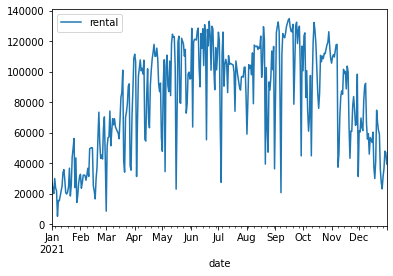

In [43]:
my_result_df.plot()